# Vehicle Detection
*Brian Erickson*

This notebook implements the *Vehicle Detection* project of the Udacity Self Driving Car NanoDegree.

It includes both investigations and the solution to the project.  

The rubric for the project is located here:

Rubric for the project is located [here](https://review.udacity.com/#!/rubrics/513/view)

## Imports and Helper Functions

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os
import os.path
import wget # conda install wget
import zipfile
import glob

import matplotlib.image as mpimg
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
import collections
import random
from profiler import Profiler
from moviepy.editor import VideoFileClip
from IPython import display

import scipy.ndimage
%matplotlib inline


In [2]:
profiler = Profiler()

In [3]:
def display_images(image_paths, columns=1,width=800,title=None,headings=None,show_filenames=True):
    '''
    displays table of images given by list of image_paths in the Jupyter notebook
    
    Parameters
    ----------
    image_paths : list of paths to image files
    columns : number of colums to display
    width : total number of pixels for entire table
    title : optional title to display
    headings : optional list of headings for columns
    '''
    column = 0
    html = ''
    if title is not None:
        html = "<b>{0}</b>".format(title)
    html += "<table><tr>"
    if headings is not None:
        for heading in headings:
            html+="<td><b>{0}</b></td>".format(heading)
        html += "</tr><tr>"
    for image_path in image_paths:
        column += 1
        if column > columns:
            column = 1
            html += "</tr><tr>"
        html += "<td>"
        html += "<a href={0}?{r} target='_blank'>".format(image_path,r=np.random.randint(1000000))
        html += "<img width={size} height={size} src='{0}?{r}'>".format(image_path,size=width//columns,r=np.random.randint(1000000))
        html += "</a>"
        if show_filenames:
            html += "<a href={0}?{r} target='_blank'>{0}</a>".format(image_path,r=np.random.randint(1000000))
        html += "</td>"
    
    html += "</tr></table>"
    display.display(display.HTML(html))

In [4]:
def display_images_side_by_side(left_images,right_images,width=800,title=None,headings=None):
    '''
    displays two lists of images side by side
    
    Parameters
    ----------
    image_paths : list of paths to image files
    columns : number of colums to display
    width : total number of pixels for entire table
    title : optional title to display
    headings : optional list of headings for columns
    '''
    lr_images = []
    for left_image,right_image in zip(left_images,right_images):
        lr_images.append(left_image)
        lr_images.append(right_image)
    display_images(lr_images, columns=2, width=width, title=title, headings=headings)

In [5]:
def process_images(input_images, process_function, prefix, output_folder = 'output_images', overwrite=True, plot=False):
    '''
    Helper function that will process images according to a process function
    
    Returns
    -------
    list of processed images
    '''
    output_paths = []
    for input_path in input_images:
        output_path = output_folder+"/"+prefix+os.path.basename(input_path)
        output_paths.append(output_path)
        if overwrite or not os.path.exists(output_path):
            im=plt.imread(input_path)
            im_processed = process_function(im)
            plt.imsave(output_path,im_processed)
        
        if plot:
            fig = plt.figure()
            fig.set_size_inches(w=10,h=5)
            plt.subplot(1,2,1)
            plt.title(input_path)
            plt.imshow(im)
            plt.subplot(1,2,2)
            plt.title(output_path)
            plt.imshow(im_processed,cmap='gray')
    return output_paths

In [6]:
def video_tag(path,width=300,height=240,title=""):
    '''
    generates an HTML fragmentfor displaying the video in path in the notebook
    '''
    return """
    <div style="float:left;padding-left:5px">
    <p>{3}</p>
    <video width="{1}" height="{2}" controls>
      <source src="{0}">
    </video>
    </div>
    """.format(path,width,height,title)

In [7]:
def process_videos(
    input_videos, 
    process_function, 
    prefix, output_folder = 'output_videos', 
    overwrite=False,
    plot=True,
    time_range = None
):
    '''
    Applies process_function to a list of videos, generating a corresponding list of output videos
    '''
    output_paths = []

    
    for input_path in input_videos:
        output_path = output_folder+"/"+prefix+'_'+os.path.basename(input_path)
        output_paths.append(output_path)
        if overwrite or not os.path.exists(output_path) or os.path.getmtime(output_path) < os.path.getmtime(input_path):
            clip1 = VideoFileClip(input_path)
            if time_range is not None:
                clip1=clip1.subclip(*time_range)
            white_clip = clip1.fl_image(process_function) #NOTE: this function expects color images!!
            %time white_clip.write_videofile(output_path, audio=False)
        
        if plot:
            html = video_tag(output_path,title=output_path)
            display.display(display.HTML(html))
    return output_paths

## Get Training Data

In [8]:
# vehicles
if not os.path.exists('datasets/vehicles'):
    f = wget.download('https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/vehicles.zip')
    with zipfile.ZipFile(f, 'r') as z:
        z.extractall(path='datasets')
    os.remove(f)

    

In [9]:
# non-vehicles
if not os.path.exists('datasets/non-vehicles'):
    f = wget.download('https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/non-vehicles.zip')
    with zipfile.ZipFile(f, 'r') as z:
        z.extractall(path='datasets')
    os.remove(f)


In [10]:
test_images = glob.glob('test_images/*')
test_images.sort();

In [11]:
display_images(test_images,columns=3,title='Test Images')

In [12]:
# Read in car and non-car images
cars = glob.glob('datasets/vehicles/**/*.png',recursive=True)
notcars = glob.glob('datasets/non-vehicles/**/*.png',recursive=True)
images= cars+notcars

print('cars:',len(cars),' noncars:',len(notcars), ' total:',len(cars)+len(notcars))



cars: 8792  noncars: 8968  total: 17760


In [13]:
display_images(random.sample(cars,100),title='100 random cars',columns=10,show_filenames=False)

In [14]:
display_images(random.sample(notcars,100),title='100 random non-cars',columns=10,show_filenames=False)

## Investigations

### Color Spaces

In [72]:
colorspaces = ['RGB','HSV','LUV','HLS','YUV','YCrCb']

In [16]:
def rgb_to_colorspace(image, colorspace):
    if image.dtype == 'float32':
        im=(image * 255).astype(np.uint8)
    else:
        im = image
    #im=image.astype(np.float32)/np.max(image)
    rv = None
    if colorspace == 'RGB':
        rv = np.copy(im)
    elif colorspace == 'HSV':
        rv = cv2.cvtColor(im, cv2.COLOR_RGB2HSV)
    elif colorspace == 'LUV':
        rv = cv2.cvtColor(im, cv2.COLOR_RGB2LUV)
    
    elif colorspace == 'HLS':
        rv = cv2.cvtColor(im, cv2.COLOR_RGB2HLS)
    elif colorspace == 'YUV':
        rv = cv2.cvtColor(im, cv2.COLOR_RGB2YUV)
    elif colorspace == 'YCrCb':
        rv = cv2.cvtColor(im, cv2.COLOR_RGB2YCrCb)
    else:
        raise ValueError("unsupported colorspace "+str(colorspace))
        
    if np.min(rv)<0:
        raise ValueErrr ('negative color returned')
    return rv


channel 0 range 0 - 255, channel 1 range 0 - 255, channel 2 range 0 - 255, 
channel 0 range 29 - 175, channel 1 range 38 - 177, channel 2 range 34 - 175, 
channel 0 range 33 - 159, channel 1 range 39 - 169, channel 2 range 42 - 171, 


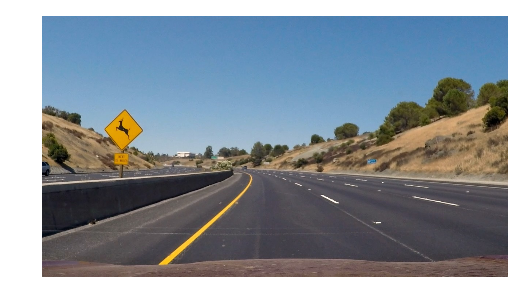

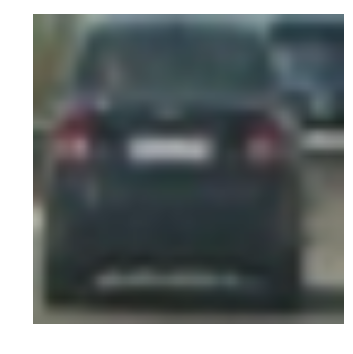

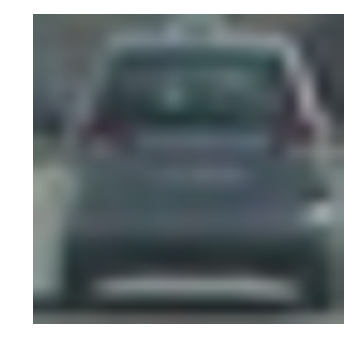

In [17]:
# ensure color ranges are OK
images = (plt.imread('test_images/test2.jpg'),scipy.ndimage.imread('datasets/vehicles/GTI_MiddleClose/image0000.png',mode='RGB'),plt.imread('datasets/vehicles/GTI_Far/image0003.png'))
for image in images:
        im=rgb_to_colorspace(image,'RGB')
        for channel in range(3):
            print('channel',channel,'range',np.min(im[:,:,channel]),'-',np.max(im[:,:,channel]),end=', ')
        plt.figure()
        plt.imshow(im)
        plt.axis('OFF')
            
        print()


### Color Classify
based on lesson 26

In [18]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
# NOTE: the next import is only valid 
# for scikit-learn version <= 0.17
# if you are using scikit-learn >= 0.18 then use this:
from sklearn.model_selection import train_test_split

# Define a function to compute binned color features  
def bin_spatial(img, size=32):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, (size,size)).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

def get_color_features(im, spatial_size, hist_bins, hist_range):
    '''
    returns color features for single image
    
    im must already be in the correct color space
    '''
    spatial_features = bin_spatial(im, size=spatial_size)
    hist_features = color_hist(im, nbins=hist_bins, bins_range=hist_range)
    features = np.concatenate((spatial_features, hist_features))
    return features


In [19]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orientations, pixels_per_cell, cells_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orientations, pixels_per_cell=(pixels_per_cell, pixels_per_cell),
                                  cells_per_block=(cells_per_block, cells_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orientations, pixels_per_cell=(pixels_per_cell, pixels_per_cell),
                       cells_per_block=(cells_per_block, cells_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

def hog_features_for_patch(im,hog_channel,orientations,pixels_per_cell,cells_per_block):
        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(im.shape[2]):
                hog_features.append(get_hog_features(im[:,:,channel], 
                                    orientations, pixels_per_cell, cells_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(im[:,:,hog_channel], orientations, 
                        pixels_per_cell, cells_per_block, vis=False, feature_vec=True)    
        return hog_features



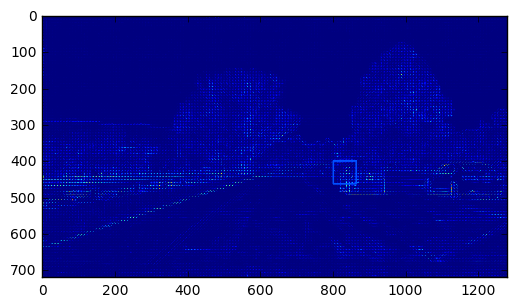

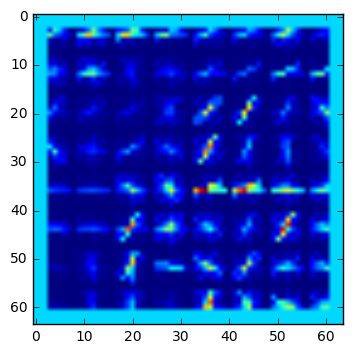

In [68]:
im=plt.imread(test_images[0])
features,hog_image = get_hog_features(im[:,:,0],orientations=16,pixels_per_cell=8,cells_per_block=1,vis=True)
plt.figure()
x1,x2,y1,y2=400,463,800,863
cv2.rectangle(hog_image,(800,400),(863,463),(1,1,1),thickness=4)
plt.imshow(hog_image)
plt.figure()
plt.imshow(hog_image[400:464,800:864])
plt.imsave('output_images/hog_image.png',hog_image)
plt.imsave('output_images/hog_detail_image.png',hog_image[400:464,800:864])



#### Try HOG on Test Image

In [21]:
def smaller_size(im):
    return cv2.resize(im,(10*im.shape[1]//14,10*im.shape[0]//14))

In [22]:
class CarDetector:
    pass

In [23]:
def car_detector_init(self):
    self.sample_size = 9999999
    self.ignore_hog = False
    self.colorspace = 'LUV'
    self.orientations = 18
    self.pixels_per_cell = 8
    self.cells_per_block = 1 # was 2, tried 8
    self.hog_channel = 'ALL'
    self.spatial_size = 16
    self.hist_bins = 12
    self.hist_range = (0,256)
CarDetector.__init__ = car_detector_init

In [24]:
def car_detector_describe(self):
        s = "features: {} accuracy: {}\n".format(self.feature_count, self.accuracy)
        s += "\nsample_size: "+str(self.sample_size)
        s += "\ncolorspace: "+str(self.colorspace)
        s += "\norientations: "+str(self.orientations)
        s += "\npixels_per_cell: "+str(self.pixels_per_cell)
        s += "\ncells_per_block: "+str(self.cells_per_block)
        s += "\nhog_channel: "+str(self.hog_channel)
        s += "\nspatial_size: " + str(self.spatial_size)
        s += "\nhist_bins: " + str(self.hist_bins)
        s += "\nignore_hog: " + str(self.ignore_hog)
        return s
CarDetector.describe = car_detector_describe
        

In [25]:
def car_detector_get_features(self, im):
    fc = get_color_features(im,self.spatial_size,self.hist_bins,self.hist_range)
    if self.ignore_hog:
        return fc
    fh = hog_features_for_patch(
        im,
        hog_channel =self.hog_channel,
        orientations = self.orientations, 
        pixels_per_cell=self.pixels_per_cell, 
        cells_per_block=self.cells_per_block)

    f = np.concatenate((fc,fh))    
    return f
CarDetector.get_features = car_detector_get_features

In [26]:
def car_detector_extract_features_from_files(self, files):
    features = []
    # Iterate through the list of images
    for file in files:
        # Read in each one by one
        im = mpimg.imread(file)
        feature_image = rgb_to_colorspace(im, self.colorspace)
        f = self.get_features(feature_image)
        features.append(f)
    return features
CarDetector.extract_features_from_files = car_detector_extract_features_from_files
    

In [27]:
def car_detector_train(
    self, 
    sample_size = None, 
    colorspace = None, 
    orientations=None, 
    pixels_per_cell=None, 
    cells_per_block=None,
    hog_channel = None,
    spatial_size = None,
    hist_bins = None,
    ignore_hog = None
):
    # Logic below is so that parameters are additive between calls
    if sample_size is not None:
        self.sample_size = sample_size
    if ignore_hog is not None:
        self.ignore_hog = ignore_hog
    if colorspace is not None:
        self.colorspace = colorspace
    if orientations is not None:
        self.orientations = orientations
    if pixels_per_cell is not None:
        self.pixels_per_cell = pixels_per_cell
    if cells_per_block is not None:
        self.cells_per_block = cells_per_block
    if hog_channel is not None:
        self.hog_channel = hog_channel
    if spatial_size is not None:
        self.spatial_size = spatial_size
    if hist_bins is not None:
        self.hist_bins = hist_bins
    if ignore_hog is not None:
        self.ignore_hog = ignore_hog
    
    hog_cars = random.sample(cars,min(self.sample_size,len(cars)))
    hog_not_cars = random.sample(notcars,min(self.sample_size,len(notcars)))
    
    car_features = self.extract_features_from_files(hog_cars)
    not_car_features = self.extract_features_from_files(hog_not_cars)

    
    X = np.vstack((car_features, not_car_features)).astype(np.float64)                        
    scaler = StandardScaler().fit(X)
    scaled_X = scaler.transform(X)
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(not_car_features))))
    X_train, X_test, y_train, y_test = train_test_split(
        scaled_X, y, test_size=0.2)

    feature_count = len(X_train[0])
    svc = LinearSVC()
    svc.fit(X_train, y_train)
    accuracy = svc.score(X_test, y_test)
    
    
    self.accuracy = accuracy
    self.feature_count = feature_count
    self.svc = svc
    self.scaler=scaler
    
CarDetector.train = car_detector_train

In [28]:
%%time
detector = CarDetector()
detector.train(sample_size=99999)
print(detector.describe())


features: 4260 accuracy: 0.9932432432432432

sample_size: 99999
colorspace: LUV
orientations: 18
pixels_per_cell: 8
cells_per_block: 1
hog_channel: ALL
spatial_size: 16
hist_bins: 12
ignore_hog: False
CPU times: user 1min 27s, sys: 568 ms, total: 1min 28s
Wall time: 1min 28s


In [29]:
def car_detector_detect(self, im):
    '''
    returns true if im is a car
    
    im must be in the transformed colorspace
    '''
    #profiler.start("get_features")
    f = self.get_features(im).reshape(1, -1)
    #profiler.start('transform')
    f_scaled = self.scaler.transform(f)
    #print(f_scaled)
    #profiler.start('predict')
    is_car = self.svc.predict(f_scaled)[0]==1.
    return is_car
CarDetector.detect = car_detector_detect
    

In [30]:
def car_detector_detect_file(self,file):
    im = rgb_to_colorspace(mpimg.imread(file),self.colorspace)
    #f = self.get_features(im).reshape(1, -1)
    #f_scaled = self.scaler.transform(f)
    #is_car = self.svc.predict(f_scaled)
    #print(np.max(im),np.min(im))
    return self.detect(im)

CarDetector.detect_file = car_detector_detect_file

In [31]:
print(detector.detect_file(cars[0]))
print(detector.detect_file(notcars[0]))

True
False


In [32]:
def car_detector_find_and_draw_detections(self, im):
    im2=rgb_to_colorspace(im, self.colorspace)#.astype(np.float64)
    #print(np.max(im2),np.min(im2))
    image_height = im.shape[0]
    image_width = im.shape[1]
    tile_width=64
    tile_height=64
    for x in range(0, image_width-tile_width-1, tile_width//3):
        #for y in range(image_height//2, image_height-tile_height-1, tile_height//2):
        for y in range(0, image_height-tile_height-1, tile_height//2):
            v = im2[y:y+tile_height,x:x+tile_width,:]
            is_car = self.detect(v)
            color = (255,0,0) if is_car else (127,127,127)
            thickness = 3 if is_car else 1
            if is_car:
                cv2.rectangle(im,(x,y),(x+tile_width,y+tile_height),color,thickness=thickness)
    return im
                
CarDetector.find_and_draw_detections = car_detector_find_and_draw_detections

In [33]:
print(detector.describe())

features: 4260 accuracy: 0.9932432432432432

sample_size: 99999
colorspace: LUV
orientations: 18
pixels_per_cell: 8
cells_per_block: 1
hog_channel: ALL
spatial_size: 16
hist_bins: 12
ignore_hog: False


In [34]:
def draw_boxes(im, boxes, color=(0, 0, 255), thick=6):
    for p1,p2 in boxes:
        cv2.rectangle(im, p1, p2, color, thick)
    return im

In [35]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def car_detector_find_cars(
    self,
    img,
    bbox=None,
    scale=1.0, 
    get_all_boxes=False
):
    found_cars = []
    
    if bbox is not None:
        xstart = bbox[0][0]
        xstop = bbox[1][0]
        ystart = bbox[0][1]
        ystop = bbox[1][1] 
    else:
        xstart = 0
        xstop = img.shape[1]
        ystart = 0
        ystop = img.shape[0]
   
    img_tosearch = img[ystart:ystop+1,xstart:xstop+1,:]
    ctrans_tosearch = rgb_to_colorspace(img_tosearch, self.colorspace)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = ch1.shape[1] // self.pixels_per_cell
    nyblocks = ch1.shape[0] // self.pixels_per_cell
    #print('nxblocks',nxblocks)
    #nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = window // self.pixels_per_cell 
    cells_per_step = 2 # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    #print(nxsteps,nysteps)
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, self.orientations, self.pixels_per_cell, self.cells_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, self.orientations, self.pixels_per_cell, self.cells_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, self.orientations, self.pixels_per_cell, self.cells_per_block, feature_vec=False)
    
    for xb in range(nxsteps+1):
        for yb in range(nysteps+1):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*self.pixels_per_cell
            ytop = ypos*self.pixels_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            color_features = get_color_features(subimg, self.spatial_size, self.hist_bins, self.hist_range)
                
            #spatial_features = bin_spatial(subimg, size=spatial_size)
            #hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            #print('spatial_features',spatial_features.shape, 'hist_features', hist_features.shape, 'hog_features', hog_features.shape)
            #unscaled_features = np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1)
            unscaled_features = np.hstack((color_features, hog_features)).reshape(1, -1)
            #print(unscaled_features)
            #print('unscaled_features',unscaled_features.shape)
            test_features = self.scaler.transform(unscaled_features)
            #print(test_features)
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = self.svc.predict(test_features)
            
            if test_prediction == 1 or get_all_boxes:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                box = ((xbox_left+xstart, ytop_draw+ystart),(xbox_left+xstart+win_draw,ytop_draw+win_draw+ystart))
                found_cars.append(box)
                
    return found_cars

CarDetector.find_cars = car_detector_find_cars

In [36]:
def process_at_scale(im, detector, scale):
    imout = np.copy(im)
    car_boxes = detector.find_cars(im,scale=scale,bbox=((0,400),(im.shape[1],im.shape[0])))
    draw_boxes(imout,car_boxes)
    return imout
    
for scale in [1,1.4,2,2.8,4]:
    processed = process_images(
        process_function = lambda f: process_at_scale(f,detector,scale), 
        input_images=test_images,
        prefix='scale'+str(scale))
    display_images(processed,title='scale:'+str(scale),columns=3)


In [37]:
for scale in [1,1.4,2,2.8]:
    process_videos(
        ['test_video.mp4'],
        output_folder='output_videos',
        process_function=lambda f: process_at_scale(f,detector,scale),
        prefix='s'+str(scale),
        overwrite=False)

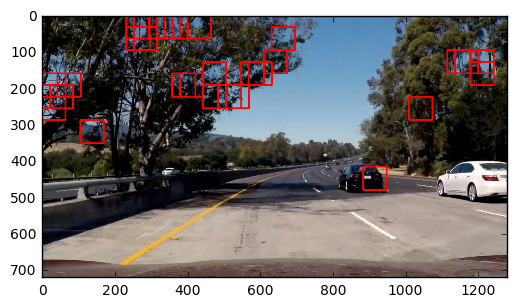

In [38]:
im = detector.find_and_draw_detections(plt.imread('test_images/test5.jpg'))
plt.imshow(im)

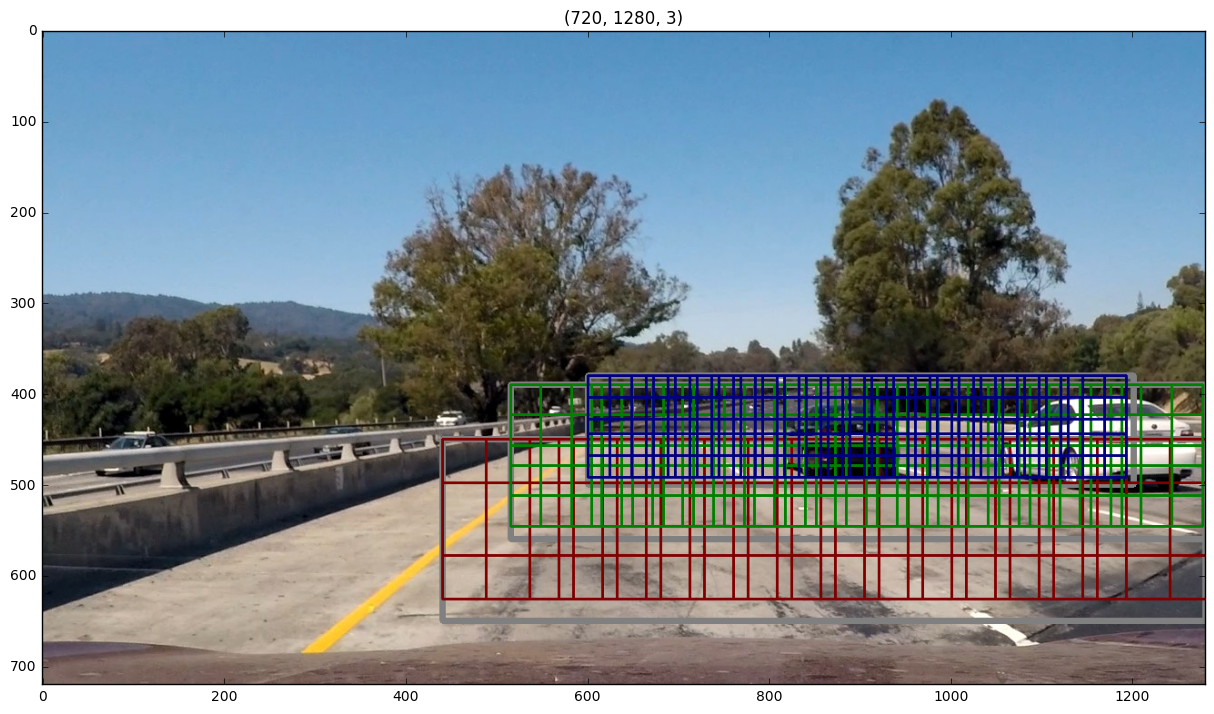

In [69]:
fig=plt.figure()
fig.set_size_inches(w=15,h=10)
im = plt.imread(test_images[0])
plt.title(str(im.shape))
#display_images(test_images[0:1])
boxes=[
    ((440,450),(1279,650)),
    ((515,390),(1279,560)),
    ((600,380),(1200,500)),
    #((650,400),(875,450))
      ]
scales = [2.0,1.4,1.0]
colors = [(128,0,0),(0,128,0),(1,1,128),(1,128,128)]
draw_boxes(im,boxes,color=(128,128,128))

for box,scale,color in zip(boxes,scales,colors):
    #print(str(box),str(scale),str(color))
    boxes = detector.find_cars(im,scale=scale, bbox=box, get_all_boxes = True)
    draw_boxes(im,boxes,thick=2,color=color)
plt.imshow(im)
plt.imsave('output_images/multiscale_search_window.png',im)


In [40]:
def car_detector_find_cars_multiscale(self, im):
    boxes=[
    ((440,450),(1279,650)),
    ((515,410),(1279,560)),
    ((600,380),(1200,500))
          ]
    scales = [2.0,1.4,1.0]
    found_cars = []
    for bbox,scale in zip(boxes,scales):
        found_cars.extend(self.find_cars(im,bbox=bbox,scale=scale))
    return found_cars

CarDetector.find_cars_multiscale = car_detector_find_cars_multiscale

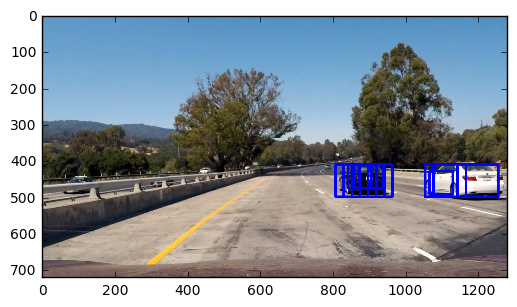

In [41]:

im=plt.imread(test_images[0])

draw_boxes(im,detector.find_cars_multiscale(plt.imread(test_images[0])))
plt.imshow(im)

In [42]:
processed = process_images(
    process_function = lambda im: draw_boxes(im,detector.find_cars_multiscale(im)),
    input_images=test_images,
    prefix='multiscale')
display_images(processed,columns=3)

In [43]:
process_videos(
    ['test_video.mp4'],
    output_folder='output_videos',
    process_function=lambda im: draw_boxes(im,detector.find_cars_multiscale(im)),
    prefix='multiscale')

['output_videos/multiscale_test_video.mp4']

In [44]:
process_videos(
    ['project_video.mp4'],
    output_folder='output_videos',
    process_function=lambda im: draw_boxes(im,detector.find_cars_multiscale(im)),
    overwrite=False,
    prefix='multiscale')

['output_videos/multiscale_project_video.mp4']

In [45]:
def get_heat_map(im,boxes,color=False,scale=1):
    if color:
        heat = np.zeros_like(im[:,:])
    else:
        heat = np.zeros_like(im[:,:,0])
    for box in boxes:
        x1 = box[0][0]
        x2 = box[1][0]
        y1 = box[0][1]
        y2 = box[1][1]
        heat[y1:y2,x1:x2,0] += scale
    return heat
    

In [46]:
def simple_heatmap(im):
    boxes = detector.find_cars_multiscale(im)
    heat_map = get_heat_map(im,boxes,True,scale=10)
    return heat_map


In [47]:
process_videos(
    ['test_video.mp4'],
    output_folder='output_videos',
    process_function=simple_heatmap,
    prefix='simple_heatmap',
    overwrite=False)

['output_videos/simple_heatmap_test_video.mp4']

In [48]:
class HeatMap:
    def __init__(self,im,color=False):
        self.heat = np.zeros_like(im,np.float)
        self.heat_rate = 10
        self.decay_rate = 10
        self.max_heat = 250
        self.threshold = 40
        self.blob_detector = cv2.SimpleBlobDetector_create()
        
    def add_frame(self, boxes):
        self.heat = np.clip(self.heat-self.decay_rate,0,255)
        for box in boxes:
            x1 = box[0][0]
            x2 = box[1][0]
            y1 = box[0][1]
            y2 = box[1][1]
            self.heat[y1:y2,x1:x2,0] += self.heat_rate
        self.heat = np.clip(self.heat,0,self.max_heat)
        
        labels,label_count = scipy.ndimage.measurements.label(self.heat[:,:,0]>self.threshold)
        boxes = []
        for car_number in range(1, label_count+1):
            # Find pixels with each car_number label value
            nonzero = (labels == car_number).nonzero()
            # Identify x and y values of those pixels
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])
            # Define a bounding box based on min/max x and y
            bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
            boxes.append(bbox)
        return boxes


In [49]:
heat_map = HeatMap(plt.imread(test_images[0]))
process_videos(
    ['test_video.mp4'],
    output_folder='output_videos',
    process_function=lambda im: draw_boxes(im,heat_map.add_frame(detector.find_cars_multiscale(im))),
    prefix='heatmap_class',
    overwrite=False)

['output_videos/heatmap_class_test_video.mp4']

In [50]:
heat_map = HeatMap(plt.imread(test_images[0]))
process_videos(
    ['project_video.mp4'],
    output_folder='output_videos',
    process_function=lambda im: draw_boxes(im,heat_map.add_frame(detector.find_cars_multiscale(im))),
    prefix='heatmap_class',
    overwrite=False)

['output_videos/heatmap_class_project_video.mp4']

### Parameter Optimizations

In [51]:
#import plotly.plotly as py
import plotly
import plotly.offline
import plotly.graph_objs as go
plotly.offline.init_notebook_mode()

import numpy as np
def show_vehicles_color_plot(colorspace='LUV'):
    data = []
    opacity = .3
    size=2

    cvt = lambda im: rgb_to_colorspace(im,colorspace)
    x=[]
    y=[]
    z=[]
    for f in glob.glob('color_spaces/vehicles/*'):
        im = cvt(plt.imread(f))
        x=np.append(x,im[:,:,0].ravel())
        y=np.append(y,im[:,:,1].ravel())
        z=np.append(z, im[:,:,2].ravel())


    data.append(go.Scatter3d(
        x=x,
        y=y,
        z=z,
        #legendgroup='vehicles',
        mode='markers',
        marker=dict(
            size=size,
            #color='rgba(255, 0, 0,1)',
            opacity=opacity
        ),
        name = 'vehicles'
    ))

    x=[]
    y=[]
    z=[]

    for f in glob.glob('color_spaces/non-vehicles/*'):
        im = cvt(plt.imread(f))
        x=np.append(x,im[:,:,0].ravel())
        y=np.append(y,im[:,:,1].ravel())
        z=np.append(z, im[:,:,2].ravel())

    data.append(go.Scatter3d(
        x=x,
        y=y,
        z=z,
        mode='markers',
        marker=dict(
            size=size,
            #color='rgba(0, 0, 0, 1)',
            opacity=opacity
        ),
        name = 'non-vehicles'
    ))


    #data = [trace1, trace2]
    layout = go.Layout(
        title='colorspace '+colorspace,
        margin=dict(
            l=0,
            r=0,
            b=0,
            t=0
        ),
        showlegend='True'
    )
    fig = go.Figure(data=data, layout=layout)
    plotly.offline.iplot(fig)#, filename='simple-3d-scatter')

In [73]:
for colorspace in colorspaces:
    show_vehicles_color_plot(colorspace)

In [53]:
detector = CarDetector()
best_accuracy = 0.0
for spatial in [4,6,8,12,16,20,24,28,32,64]:
    detector.train(ignore_hog = True, spatial_size=spatial,sample_size=1000)
    print('spatial: ',spatial, 'accuracy: ', detector.accuracy, 'feature_count: ', detector.feature_count)
    if detector.accuracy > best_accuracy:
        best_accuracy = detector.accuracy
        best_spatial = spatial
print('the best spatial was:', best_spatial)
print(detector.describe())

spatial:  4 accuracy:  0.925 feature_count:  84
spatial:  6 accuracy:  0.9175 feature_count:  144
spatial:  8 accuracy:  0.89 feature_count:  228
spatial:  12 accuracy:  0.9125 feature_count:  468
spatial:  16 accuracy:  0.9125 feature_count:  804
spatial:  20 accuracy:  0.9125 feature_count:  1236
spatial:  24 accuracy:  0.9275 feature_count:  1764
spatial:  28 accuracy:  0.9175 feature_count:  2388
spatial:  32 accuracy:  0.91 feature_count:  3108
spatial:  64 accuracy:  0.91 feature_count:  12324
the best spatial was: 24
features: 12324 accuracy: 0.91

sample_size: 1000
colorspace: LUV
orientations: 18
pixels_per_cell: 8
cells_per_block: 1
hog_channel: ALL
spatial_size: 64
hist_bins: 12
ignore_hog: True


In [54]:
spatial = best_spatial
best_accuracy = 0
for colorspace in colorspaces:
    detector.train(colorspace=colorspace, spatial_size=spatial,ignore_hog=True)
    print('colorspace: ',colorspace, 'accuracy: ', detector.accuracy, 'feature_count: ', detector.feature_count)
    if detector.accuracy > best_accuracy:
        best_accuracy = detector.accuracy
        best_colorspace = colorspace
print('the best colorspace was:', best_colorspace)
print(detector.describe())

colorspace:  RGB accuracy:  0.9075 feature_count:  1764
the best colorspace was: RGB
features: 1764 accuracy: 0.9075

sample_size: 1000
colorspace: RGB
orientations: 18
pixels_per_cell: 8
cells_per_block: 1
hog_channel: ALL
spatial_size: 24
hist_bins: 12
ignore_hog: True


In [55]:
spatial = best_spatial
colorspace = best_colorspace
best_accuracy = 0
for histbin in [8,12,16,20,24,28,32,48,64,128,256]:
    detector.train(
        sample_size=1000,
        ignore_hog = True, 
        colorspace=colorspace, 
        spatial_size=spatial,
        hist_bins=histbin)
    print('histbin: ',histbin, colorspace, 'accuracy: ', detector.accuracy, 'feature_count: ', detector.feature_count, 'histbin',histbin)
    if detector.accuracy > best_accuracy:
        best_accuracy = detector.accuracy
        best_histbin = histbin
print('the best histbin was:', best_histbin)

histbin:  8 RGB accuracy:  0.875 feature_count:  1752 histbin 8
histbin:  12 RGB accuracy:  0.9025 feature_count:  1764 histbin 12
histbin:  16 RGB accuracy:  0.9125 feature_count:  1776 histbin 16
histbin:  20 RGB accuracy:  0.935 feature_count:  1788 histbin 20
histbin:  24 RGB accuracy:  0.9025 feature_count:  1800 histbin 24
histbin:  28 RGB accuracy:  0.9325 feature_count:  1812 histbin 28
histbin:  32 RGB accuracy:  0.945 feature_count:  1824 histbin 32
histbin:  48 RGB accuracy:  0.9475 feature_count:  1872 histbin 48
histbin:  64 RGB accuracy:  0.94 feature_count:  1920 histbin 64
histbin:  128 RGB accuracy:  0.9375 feature_count:  2112 histbin 128
histbin:  256 RGB accuracy:  0.96 feature_count:  2496 histbin 256
the best histbin was: 256


In [56]:
histbin = best_histbin
best_accuracy = 0
for orientations in [3,4,5,6,7,8,9,10,11,12,14,16,18,22,24,28]:
    detector.train(
        orientations=orientations, hist_bins=best_histbin)
    print('orientations: ',orientations, 'accuracy: ',detector.accuracy, 'feature_count: ', detector.feature_count)
    if detector.accuracy > best_accuracy:
        best_accuracy = detector.accuracy
        best_orientations = orientations
print('the best orientations was:',best_orientations)

orientations:  3 accuracy:  0.9375 feature_count:  2496
orientations:  4 accuracy:  0.9475 feature_count:  2496
orientations:  5 accuracy:  0.9425 feature_count:  2496
orientations:  6 accuracy:  0.9425 feature_count:  2496
orientations:  7 accuracy:  0.9225 feature_count:  2496
orientations:  8 accuracy:  0.9325 feature_count:  2496
orientations:  9 accuracy:  0.9475 feature_count:  2496
orientations:  10 accuracy:  0.925 feature_count:  2496
orientations:  11 accuracy:  0.9325 feature_count:  2496
orientations:  12 accuracy:  0.93 feature_count:  2496
orientations:  14 accuracy:  0.945 feature_count:  2496
orientations:  16 accuracy:  0.9375 feature_count:  2496
orientations:  18 accuracy:  0.935 feature_count:  2496
orientations:  22 accuracy:  0.955 feature_count:  2496
orientations:  24 accuracy:  0.9375 feature_count:  2496
orientations:  28 accuracy:  0.9475 feature_count:  2496
the best orientations was: 22


In [57]:
print(detector.describe())

features: 2496 accuracy: 0.9475

sample_size: 1000
colorspace: RGB
orientations: 28
pixels_per_cell: 8
cells_per_block: 1
hog_channel: ALL
spatial_size: 24
hist_bins: 256
ignore_hog: True


In [58]:
spatial = 4
colorspace = 'LUV' 
histbin = 16    # 256 was had a higher test accuracy, but I'm afraid that may over-fit

In [59]:
detector.train(
    sample_size=99999,
    ignore_hog = False, 
    colorspace=colorspace, 
    spatial_size=spatial,
    hist_bins=histbin)

In [60]:
print('spatial: ',detector.spatial_size, 'colorspace: ', detector.colorspace, 'accuracy: ', detector.accuracy, 'feature_count: ', detector.feature_count, 'histbin',detector.hist_bins)


spatial:  4 colorspace:  LUV accuracy:  0.994087837838 feature_count:  5472 histbin 16


In [61]:
best_accuracy = 0
for hog_channel in [0,1,2,'ALL']:
    detector.train(
        sample_size=1000,
        ignore_hog = False,
        colorspace=colorspace, 
        hog_channel=hog_channel,
        hist_bins=histbin)
    print('hog_channel: ',hog_channel,  'accuracy: ', detector.accuracy, 'feature_count: ', detector.feature_count)
    if detector.accuracy > best_accuracy:
        best_accuracy = detector.accuracy
        best_colorspace = colorspace
        best_hog_channel = hog_channel
print('the best hog_channel was:', best_hog_channel)
print(detector.describe())

    

hog_channel:  0 accuracy:  0.975 feature_count:  1888
hog_channel:  1 accuracy:  0.9475 feature_count:  1888
hog_channel:  2 accuracy:  0.94 feature_count:  1888
hog_channel:  ALL accuracy:  0.9825 feature_count:  5472
the best hog_channel was: ALL
features: 5472 accuracy: 0.9825

sample_size: 1000
colorspace: LUV
orientations: 28
pixels_per_cell: 8
cells_per_block: 1
hog_channel: ALL
spatial_size: 4
hist_bins: 16
ignore_hog: False


    orientations:  3 colorspace:  HLS hog_channel:  0 accuracy:  0.885 feature_count:  2700
    orientations:  4 colorspace:  HLS hog_channel:  0 accuracy:  0.915 feature_count:  3600
    orientations:  5 colorspace:  HLS hog_channel:  0 accuracy:  0.925 feature_count:  4500
    orientations:  6 colorspace:  HLS hog_channel:  0 accuracy:  0.94 feature_count:  5400
    orientations:  7 colorspace:  HLS hog_channel:  0 accuracy:  0.965 feature_count:  6300
    orientations:  8 colorspace:  HLS hog_channel:  0 accuracy:  0.955 feature_count:  7200
    orientations:  9 colorspace:  HLS hog_channel:  0 accuracy:  0.93 feature_count:  8100
    orientations:  10 colorspace:  HLS hog_channel:  0 accuracy:  0.94 feature_count:  9000
    orientations:  11 colorspace:  HLS hog_channel:  0 accuracy:  0.955 feature_count:  9900
    orientations:  12 colorspace:  HLS hog_channel:  0 accuracy:  0.98 feature_count:  10800
    the best colorspace was: HSV
    the best hog_channel was: ALL

In [66]:
for hog_channel in [0,'ALL']:
    colorspace = 'LUV'
    orientations = 12
    best_accuracy = 0
    for pixels_per_cell in [3,4,5,6,7,8,9,10,11,12]:
        detector.train(
            sample_size=1000,
            ignore_hog = False,
            pixels_per_cell = pixels_per_cell, 
            hog_channel=hog_channel,
            hist_bins=histbin)
        print('pixels_per_cell',pixels_per_cell, 'orientations: ',orientations, 'accuracy: ', detector.accuracy, 'feature_count: ', detector.feature_count)
        if detector.accuracy > best_accuracy:
            best_accuracy = detector.accuracy
            best_pixels_per_cell = pixels_per_cell
            best_hog_channel = hog_channel
    print('the best_pixels_per_cell was:', best_pixels_per_cell)
    print('the best hog_channel was:', best_hog_channel)

pixels_per_cell 3 orientations:  12 accuracy:  0.9525 feature_count:  12444
pixels_per_cell 4 orientations:  12 accuracy:  0.95 feature_count:  7264
pixels_per_cell 5 orientations:  12 accuracy:  0.975 feature_count:  4128
pixels_per_cell 6 orientations:  12 accuracy:  0.9525 feature_count:  2896
pixels_per_cell 7 orientations:  12 accuracy:  0.9625 feature_count:  2364
pixels_per_cell 8 orientations:  12 accuracy:  0.955 feature_count:  1888
pixels_per_cell 9 orientations:  12 accuracy:  0.965 feature_count:  1468
pixels_per_cell 10 orientations:  12 accuracy:  0.9675 feature_count:  1104
pixels_per_cell 11 orientations:  12 accuracy:  0.975 feature_count:  796
pixels_per_cell 12 orientations:  12 accuracy:  0.98 feature_count:  796
the best_pixels_per_cell was: 12
the best hog_channel was: 0
pixels_per_cell 3 orientations:  12 accuracy:  0.975 feature_count:  37140
pixels_per_cell 4 orientations:  12 accuracy:  0.9825 feature_count:  21600
pixels_per_cell 5 orientations:  12 accuracy